#                                Browser fingerprint analysis 

## Importing of necessary librairies

In [80]:
import MySQLdb as mdb
import numpy as np
import csv
import sys
import re
sys.path.append("../src/")
from src.fingerprint import Fingerprint
from src import CSV_DELIMITER

import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH_REL = "../../data/"

#Matplotlib figures inserted into the notebook
%pylab inline

import mpl_toolkits
mpl_toolkits.__path__.append('/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

## Read the file

In [81]:
# Exclusion of some attributes
ATTRIBUTES_TO_EXCLUDE = [Fingerprint.COUNTER, Fingerprint.CREATION_TIME, Fingerprint.END_TIME, Fingerprint.CONSISTENT]

In [82]:
# read the file
df = pd.read_csv(DATA_PATH_REL + "processed/fingerprint_dataset.csv", delimiter=CSV_DELIMITER, engine="python")

## Visualization of consistent fingerprints

In [83]:
# Analysis of consistent fingerprints
attributes_to_analyze = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]
df_consistent = df[df[Fingerprint.CONSISTENT] == True ]
print("There are {:d} elements in df_consistent".format(len(df_consistent)))

There are 49271 elements in df_consistent


In [7]:
# Name of attributes
print(df_consistent.columns, "There are {:d} columns in df_consistent".format(len(df_consistent.columns)))

Index(['counter', 'id', 'creationDate', 'endDate', 'addressHttp',
       'userAgentHttp', 'acceptHttp', 'connectionHttp', 'encodingHttp',
       'languageHttp', 'orderHttp', 'pluginsJSHashed', 'platformJS',
       'cookiesJS', 'dntJS', 'timezoneJS', 'resolutionJS', 'localJS',
       'sessionJS', 'canvasJSHashed', 'fontsFlashHashed', 'resolutionFlash',
       'languageFlash', 'platformFlash', 'browserFamily',
       'globalBrowserVersion', 'minorBrowserVersion', 'majorBrowserVersion',
       'os', 'rendererWebGLJS', 'vendorWebGLJS', 'pluginsJS', 'consistent'],
      dtype='object') There are 33 columns in df_consistent


In [8]:
# Visualization of the first 5 lines
df_consistent.head(5)

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
15,17,0f4f77e3-80da-4b4a-b9c0-f5e8c4239380,2015-07-27 11:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
17,19,74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
18,20,df46c5fb-9889-4ff4-9f51-e5af591f3460,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
19,21,dc031028-a4ea-4ce8-a362-17b07a4f4d65,2015-07-27 12:00:00,2015-07-28 11:00:00,90f2974eff1d1b3f05d01f413cf0241fae23352e,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_4...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Mac OS 10.10.4,Chrome,440,0,44,Mac OS X,Intel HD Graphics 5000 OpenGL Engine,Intel Inc.,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
20,22,d51d09c6-2596-4958-bfe7-0352af2aaccf,2015-07-27 12:00:00,2015-07-29 06:00:00,2515ee56512877237d467911f5c55be53eea3550,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Linux,Chrome,430,0,43,Linux,Not supported,Not supported,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True


In [117]:
print("Statistics on dataset filtered: only consistent browsers")
for attribute in attributes_to_analyze:
    nb_distinct_values = df_consistent[attribute].value_counts().count()
    print("{} : {:d} distinct values".format(attribute, nb_distinct_values))

Statistics on dataset filtered: only consistent browsers
id : 4651 distinct values
addressHttp : 15781 distinct values
userAgentHttp : 2289 distinct values
acceptHttp : 7 distinct values
connectionHttp : 1 distinct values
encodingHttp : 12 distinct values
languageHttp : 424 distinct values
orderHttp : 114 distinct values
pluginsJSHashed : 4247 distinct values
platformJS : 17 distinct values
cookiesJS : 2 distinct values
dntJS : 2 distinct values
timezoneJS : 33 distinct values
resolutionJS : 446 distinct values
localJS : 2 distinct values
sessionJS : 2 distinct values
canvasJSHashed : 938 distinct values
fontsFlashHashed : 4684 distinct values
resolutionFlash : 257 distinct values
languageFlash : 27 distinct values
platformFlash : 222 distinct values
browserFamily : 18 distinct values
globalBrowserVersion : 78 distinct values
minorBrowserVersion : 21 distinct values
majorBrowserVersion : 43 distinct values
os : 14 distinct values
rendererWebGLJS : 489 distinct values
vendorWebGLJS : 13

## Descriptive analysis of consistent fingerprints

In [25]:
# entropy
def compute_entropy(df, attribute):
    entropy = 0
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    serie = df_stats[attribute].value_counts()
    
    if len(serie) == 1:
        return 0
    
    total_values = serie.sum()
    for index, value in serie.iteritems():
        pi = float(value)/float(total_values)
        entropy += pi * np.log2(pi)
    
    return -entropy

def compute_normalized_entropy(df, attribute):
    number_distinct = df[attribute].value_counts().sum()
    
    if number_distinct == 1:
        return 0
    
    pi_worst = 1.0 / float(number_distinct)
    worst_case = -number_distinct * pi_worst * np.log2(pi_worst)
    
    df[attribute].value_counts().count()
    entropy = compute_entropy(df, attribute)
    return entropy / worst_case


print("Entropy on dataset filtered: only consistent browsers")
for attribute in attributes_to_analyze:
    entropy = compute_normalized_entropy(df_consistent, attribute)
    print("{} : {:f} bits".format(attribute, entropy))

Entropy on dataset filtered: only consistent browsers
id : 0.781561 bits
addressHttp : 0.888301 bits
userAgentHttp : 0.613847 bits
acceptHttp : 0.064851 bits
connectionHttp : 0.000000 bits
encodingHttp : 0.122460 bits
languageHttp : 0.320505 bits
orderHttp : 0.193803 bits
pluginsJSHashed : 0.610079 bits
platformJS : 0.108445 bits
cookiesJS : 0.008708 bits
dntJS : 0.063739 bits
timezoneJS : 0.227500 bits
resolutionJS : 0.289189 bits
localJS : 0.031249 bits
sessionJS : 0.031101 bits
canvasJSHashed : 0.487428 bits
fontsFlashHashed : 0.542996 bits
resolutionFlash : 0.232677 bits
languageFlash : 0.164726 bits
platformFlash : 0.222875 bits
browserFamily : 0.087173 bits
globalBrowserVersion : 0.269478 bits
minorBrowserVersion : 0.019851 bits
majorBrowserVersion : 0.264609 bits
os : 0.171668 bits
rendererWebGLJS : 0.266548 bits
vendorWebGLJS : 0.116709 bits
pluginsJS : 0.630395 bits


In [43]:
# terms : effective, %
# number of unique terms
# most common terms
def terms_analysis(df, attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_stats[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))

There are 4651 unique fingerprints.

               effective          %
Windows 7           1405  30.208557
Windows 10          1218  26.187917
Mac OS X             566  12.169426
Linux                494  10.621372
Windows 8.1          380   8.170286
Ubuntu               303   6.514728
Windows XP           112   2.408084
Chrome OS             71   1.526553
Windows 8             55   1.182541
Windows Vista         23   0.494517
Other                 12   0.258009
OpenBSD                7   0.150505
FreeBSD                4   0.086003
NetBSD                 1   0.021501



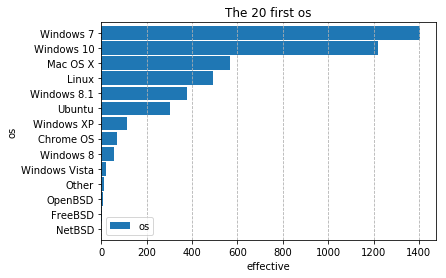

There are 1 unique terms for the attribute 'os'

The most used terms are: 
Windows 7      1405
Windows 10     1218
Mac OS X        566
Linux           494
Windows 8.1     380
Name: os, dtype: int64


In [44]:
terms_analysis(df_consistent, 'os')

The distinct values for the attribute 'languageHttp' are : 
 ['de' 'pt' 'ru' 'en' 'fr' 'cs' 'da' 'it' 'nl' 'sv' 'sl' 'es' 'nb' 'hu'
 'pl' 'sh' 'ja' 'ac' 'uk' 'zh' 'tr' 'az' 'sk' 'fi' 'ko' 'th' 'vi' 'hr'
 'ro' 'an' 'ch' 'ca' 'ar' 'lt' 'el' 'af' 'bg' 'et']

    effective          %
en       2672  53.968895
ru        850  17.168249
fr        583  11.775399
de        320   6.463341
es         79   1.595637
it         61   1.232074
pl         59   1.191678
zh         57   1.151283
nl         52   1.050293
pt         42   0.848313
hu         35   0.706928
cs         21   0.424157
ja         18   0.363563
uk         13   0.262573
da         12   0.242375
tr          8   0.161584
ac          8   0.161584
sv          8   0.161584
fi          6   0.121188
vi          6   0.121188
ko          5   0.100990
sk          5   0.100990
af          4   0.080792
hr          4   0.080792
lt          3   0.060594
sl          3   0.060594
el          2   0.040396
nb          2   0.040396
sh          2   0.0

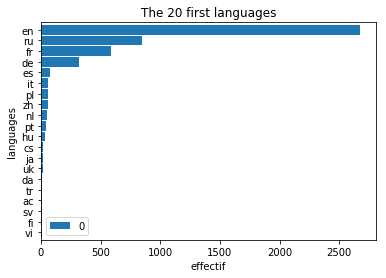

There are 7 unique terms for the attribute 'languageHttp'

The most used terms are: 
en    2672
ru     850
fr     583
de     320
es      79
Name: 0, dtype: int64


In [10]:
# terms analysis for the attribute 'languageHttp'
tmp_stats = []
ids = set(df_consistent['id'].unique())
for user_id in ids:
    df_user_id = df_consistent[df_consistent['id'] == user_id]
    different_values = df_user_id['languageHttp'].unique()
    for value in different_values:
        tmp_stats.append({
            "id": user_id,
            'languageHttp' : value
        })
df_stats = pd.DataFrame(tmp_stats)

language_http=df_stats['languageHttp']
language_http_less_nan=language_http.dropna()
language_http_less_nan_list= language_http_less_nan.values.tolist()

languages = []
for i in range(0,len(language_http_less_nan_list)):    
    languages.append(language_http_less_nan_list[i][:2])

langues_df = pd.DataFrame(languages)

print("The distinct values for the attribute 'languageHttp' are : \n {}".format(langues_df[0].unique()))

    
nb = langues_df[0].value_counts()
df_nb = pd.DataFrame(nb)
    
nb_percent = nb/nb.sum()*100
df_nb_percent = pd.DataFrame(nb_percent)
    
tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
tab.columns = ['effective', '%']

print()
print(tab)
print()

df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle = 'dashed')
plt.title('The 20 first languages')
plt.xlabel('effective')
plt.ylabel('languages')
plt.show()

print("There are {:d} unique terms for the attribute 'languageHttp'".format(len(nb[nb.values == 1])))
print()
print("The most used terms are: \n{}".format(nb[:5]))


In [102]:
#modality of plugins
tmp_stats = []
plugins=re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(df_consistent['pluginsJS']))
plugins_df=pd.DataFrame(plugins)
plugins_df[0].unique()

array(['Chrome PDF Viewer', 'Chromium PDF Viewer',
       'Default Browser Helper', 'Shockwave Flash', 'DivX',
       'Gnome Shell Integration', 'Google Update', 'Native Client',
       'Adobe Acrobat'], dtype=object)

In [140]:
def analyse_terms_splited(df, attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    attribute: value_tmp
                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_tmp[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))
    print()
    print("There are {:d} {}".format(len(nb), attribute))
    
def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_accept_http(accept):
    return accept.split(",")

def split_encoding_http(encoding):
    return encoding.split(", ")

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]
 

              effective          %
gzip               5058  31.320825
deflate            5057  31.314632
br                 3647  22.583442
sdch               2364  14.638677
lzma                  9   0.055731
identity              4   0.024769
                      3   0.018577
peerdist              1   0.006192
exi                   1   0.006192
compress              1   0.006192
xpress                1   0.006192
xz                    1   0.006192
bzip2                 1   0.006192
pack200-gzip          1   0.006192



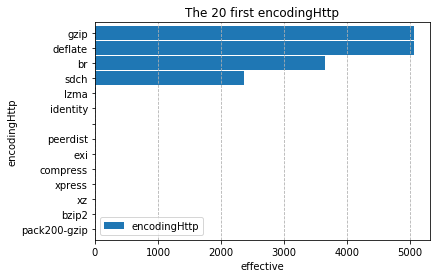

There are 7 unique terms for the attribute 'encodingHttp'

The most used terms are: 
gzip       5058
deflate    5057
br         3647
sdch       2364
lzma          9
Name: encodingHttp, dtype: int64

There are 14 encodingHttp


In [141]:
analyse_terms_splited(df_consistent, 'encodingHttp', split_encoding_http)

In [125]:
def analyze_grouped(df, attribute, group_by_attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user,
                attribute: value
            })
  
    df_stats = pd.DataFrame(tmp_stats)
    stats_grouped = df_stats[group_by_attribute].value_counts()
   # print(stats_grouped.iteritems)
    grouped = df_stats.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += abs(number - count_per_group[key])
            except KeyError:
                norm += abs(number)

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

In [126]:
analyze_grouped(df_consistent,'orderHttp', 'os')

Accept Accept-Charset Accept-Encoding Accept-Language Connection Cookie DNT Host Upgrade-Insecure-Requests User-Agent X-Real-IP
Windows 8.1    1
Name: os, dtype: int64
5985
Accept Accept-Charset Accept-Encoding Accept-Language Connection Cookie DNT Host User-Agent X-Real-IP
Windows 7    1
Name: os, dtype: int64
5985
Accept Accept-Charset Accept-Encoding Accept-Language Connection Cookie Host User-Agent X-Real-IP
Windows 8.1    2
Name: os, dtype: int64
5984
Accept Accept-Charset Accept-Encoding Accept-Language Connection DNT Host Upgrade-Insecure-Requests User-Agent X-Real-IP
Windows 8.1    1
Name: os, dtype: int64
5985
Accept Accept-Charset Accept-Encoding Accept-Language Connection DNT Host User-Agent X-Real-IP
Windows 8.1    4
Name: os, dtype: int64
5982
Accept Accept-Charset Accept-Encoding Accept-Language Connection Host Upgrade-Insecure-Requests User-Agent X-Real-IP
Windows 8.1    1
Windows 7      1
Name: os, dtype: int64
5984
Accept Accept-Charset Accept-Encoding Accept-Language 

In [130]:
def analyze_grouped_splited(df, attribute, group_by_attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    "os": os_user,
                    "browserFamily": browser_user,
                    attribute: value_tmp

                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    
    stats_grouped = df_stats.groupby(group_by_attribute).size()
    print(stats_grouped)
    
    stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_tmp.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group.groupby(group_by_attribute).size()
        #count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += (number - count_per_group[key])**2
            except KeyError:
                norm += number**2

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

def split_headers(headers):
    return headers.split(" ")

def split_languages_http(languages):
    try:
        return languages.split(";")
    except AttributeError:
        return str(languages)
    
def split_accept_http(accept):
    return accept.split(",")

def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_order_http(order):
    return order.split(" ")

In [132]:
analyze_grouped_splited(df_consistent, 'orderHttp', 'browserFamily', split_order_http)

browserFamily
Chrome                         2515
Chromium                         85
Dragon                           12
Epiphany                          2
Firefox                        3207
IE Mobile                         1
Iceweasel                        34
Iron                             40
Konqueror                         1
Maxthon                           1
Opera                            16
Other                            11
Pale Moon (Firefox Variant)       2
QupZilla                          1
Rekonq                            1
SeaMonkey                         1
Vivaldi                          51
Yandex Browser                    5
dtype: int64
Accept
browserFamily
Chrome                         2515
Chromium                         85
Dragon                           12
Epiphany                          2
Firefox                        3207
IE Mobile                         1
Iceweasel                        34
Iron                             40
Konqueror       

In [105]:
analyze_grouped_splited(df_consistent, 'pluginsJS', ['os', 'browserFamily'], split_plugins)

  WeatherScope allows you to view interactive weather maps and graphs.
os        browserFamily
Mac OS X  Firefox          3
dtype: int64
12013289
 Wacom Dynamic Link Library
os           browserFamily
Windows 8.1  Firefox          1
dtype: int64
12014903
ABN AMRO e.dentifier
os          browserFamily
Windows 10  Firefox          9
dtype: int64
11992235
ABR
os          browserFamily
Windows 10  Firefox          2
dtype: int64
12010834
AOL Update
os          browserFamily
Windows 10  Chrome           1
Windows 7   Firefox          1
dtype: int64
12008812
ATT Connect Event Entry Plug-in 
os        browserFamily
Mac OS X  Firefox          3
dtype: int64
12013289
AVG SiteSafety plugin
os         browserFamily
Windows 7  Firefox          1
dtype: int64
12012309
Ace Stream P
os           browserFamily
Windows 10   Firefox          36
Windows 7    Firefox          29
Windows 8    Firefox           1
Windows 8.1  Firefox           5
             Iron              3
dtype: int64
11803942
ActiveT

Default Browser Helper
os        browserFamily
Mac OS X  Firefox          288
          Vivaldi            2
Other     Other              1
dtype: int64
11822005
DeployMe
os         browserFamily
Windows 7  Firefox          3
dtype: int64
12004601
Diag.Helper
os         browserFamily
Windows 7  Firefox          2
dtype: int64
12008454
DivX
os           browserFamily
Linux        Chrome             1
             Firefox           20
Ubuntu       Firefox          151
Windows 8.1  Firefox            8
dtype: int64
11915064
DivX Browser Plug-In
os      browserFamily
Linux   Firefox          4
Ubuntu  Firefox          8
dtype: int64
12008662
DivX Player Netscape Plugin
os          browserFamily
Windows 10  Firefox          1
dtype: int64
12013499
DivX Plus Web Player
os           browserFamily
Mac OS X     Firefox          42
Windows 10   Chrome            1
             Firefox           6
Windows 7    Firefox          10
Windows 8    Firefox           1
Windows 8.1  Firefox           3
d

Intel
os           browserFamily
Mac OS X     Firefox            2
Windows 10   Chrome            32
             Firefox          686
Windows 7    Chrome             6
             Firefox          366
Windows 8    Firefox           40
Windows 8.1  Firefox          264
Windows XP   Firefox            2
dtype: int64
8985982
InterBank RS Service Adapter
os         browserFamily
Windows 7  Firefox          1
dtype: int64
12012309
Java Applet Plug-in
os        browserFamily
Mac OS X  Chrome             1
          Firefox          321
          Vivaldi            2
Other     Other              3
dtype: int64
11808203
Java Deployment Toolkit 
os             browserFamily              
Other          Opera                            1
Windows 10     Chrome                          11
               Firefox                        584
               Opera                            7
Windows 7      Chrome                           4
               Firefox                        723
          

Orbitum Update
os         browserFamily
Windows 7  Firefox          1
dtype: int64
12012309
Outline
os           browserFamily
Windows 8.1  Firefox          1
dtype: int64
12014903
PDF Architect 
os           browserFamily
Windows 10   Firefox          27
Windows 7    Firefox          59
Windows 8.1  Firefox           2
Windows XP   Firefox          19
dtype: int64
11712019
PDF Browser Plugin 
os        browserFamily
Mac OS X  Firefox          28
dtype: int64
11990014
PDF-XChange Editor
os           browserFamily 
Windows 10   Firefox            1
Windows 7    Firefox           15
             Yandex Browser     1
Windows 8.1  Firefox            1
dtype: int64
11954582
PDF-XChange Viewer
os           browserFamily
Windows 10   Firefox          43
Windows 7    Firefox          10
Windows 8    Firefox           2
Windows 8.1  Firefox           9
Windows XP   Firefox           3
dtype: int64
11852301
PDFlite Browser Plugin
os          browserFamily
Windows 10  Firefox          2
Windows 7

SharePoint Browser Plug-in
os        browserFamily
Mac OS X  Chrome             1
          Firefox          214
dtype: int64
11853969
Shockwave Flash
os             browserFamily              
Chrome OS      Chrome                          116
FreeBSD        Firefox                           1
Linux          Chrome                          459
               Firefox                         137
               Iceweasel                         9
               Iron                              4
               Opera                             1
               QupZilla                          1
               Vivaldi                           7
Mac OS X       Chrome                          925
               Firefox                         424
               Iron                              1
               Vivaldi                           3
Other          Firefox                           1
               Other                             6
Ubuntu         Chromium                  

Windows Media Player Plug-in
os      browserFamily
Linux   Firefox          4
Ubuntu  Firefox          8
dtype: int64
12008662
Windows Media Player Plug-in 
os      browserFamily
Linux   Chrome             1
        Firefox           20
Ubuntu  Firefox          149
dtype: int64
11925868
Windows Media Player Plug-in Dynamic Link Library
os           browserFamily
Mac OS X     Opera              1
Other        Firefox            1
Windows 7    Firefox           11
Windows 8.1  Firefox            1
Windows XP   Firefox          144
dtype: int64
11943776
Windows Presentation Foundation
os             browserFamily
Windows 7      Firefox          22
Windows 8.1    Chrome            1
Windows Vista  Firefox          12
Windows XP     Firefox          76
dtype: int64
11910801
Wiz
os         browserFamily
Windows 7  Firefox          3
dtype: int64
12004601
Wolfram Mathematica
os          browserFamily
Mac OS X    Firefox           8
Windows 10  Firefox          18
Windows 7   Firefox          

In [143]:
analyse_terms_splited(df_consistent,'encodingHttp',split_function=lambda encoding: encoding.split(","))

AttributeError: 'float' object has no attribute 'split'

## Inconsistent fingerprint detection

In [48]:
# Détection of inconsistent values
df_consistent[df_consistent['browserFamily']== "IE Mobile"]["os"]

87094    Other
87096    Other
87097    Other
Name: os, dtype: object

In [49]:
# N° of the fingerprint to take off it from consistent fingerprints
df_consistent[df_consistent['browserFamily'] == "IE Mobile"]["id"]

87094    d2869d31-770a-4e4a-b91a-331c47e1e144
87096    d2869d31-770a-4e4a-b91a-331c47e1e144
87097    d2869d31-770a-4e4a-b91a-331c47e1e144
Name: id, dtype: object

In [52]:
df_consistent[df_consistent['id']== "d2869d31-770a-4e4a-b91a-331c47e1e144"]

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
87094,117423,d2869d31-770a-4e4a-b91a-331c47e1e144,2017-02-10 09:00:00,2017-02-10 09:00:00,2f998c35b04d46117baa579021107c4911fd8387,safari (compatible; MSIE 9.0; samsung Phone OS...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,Flash not detected,IE Mobile,90,0,9,Other,Not supported,Not supported,NaN,True
87096,117425,d2869d31-770a-4e4a-b91a-331c47e1e144,2017-02-10 09:00:00,2017-02-10 09:00:00,2f998c35b04d46117baa579021107c4911fd8387,safari (compatible; MSIE 9.0; samsung Phone OS...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.8",...,Flash not detected,IE Mobile,90,0,9,Other,Not supported,Not supported,NaN,True
87097,117427,d2869d31-770a-4e4a-b91a-331c47e1e144,2017-02-10 09:00:00,None,2f998c35b04d46117baa579021107c4911fd8387,safari (compatible; MSIE 9.0; samsung Phone OS...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br",en-us,...,Flash not detected,IE Mobile,90,0,9,Other,Not supported,Not supported,NaN,True
